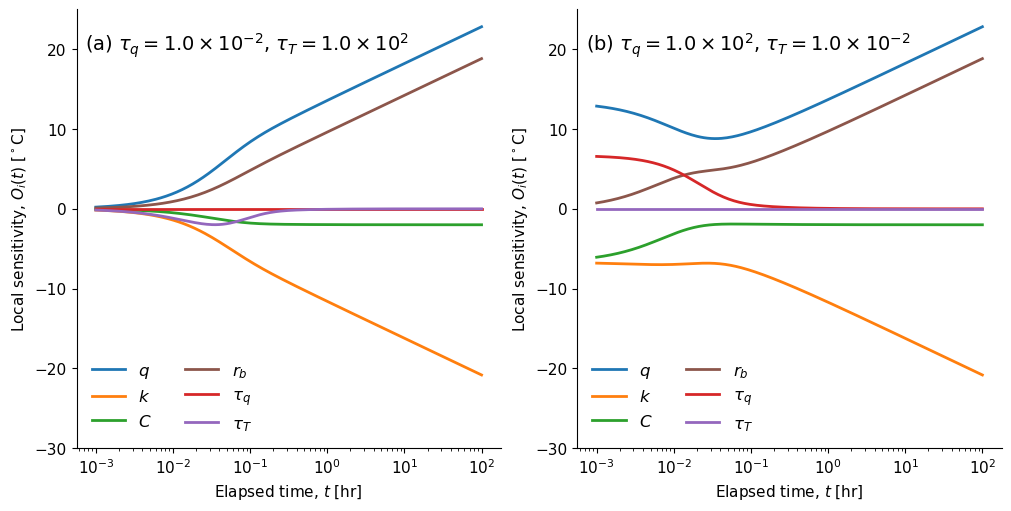

In [6]:
# ====================== Local sensitivity (time domain) — dual-lag TRT ======================
# (a) (b) 標題依照 tau_q, tau_T；全圖黑色外框；Early/Mid/Late 對齊 10^-1, 10^0, 10^1, 10^2

import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.special import kv as besselk

plt.rcParams.update({
    "font.size": 11,
    "text.usetex": False,          # 若電腦沒裝 LaTeX，False 比較穩；標籤仍用 TeX 語法
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# ---------- Stehfest inversion ----------
def stehfest_inversion(t, func, args, N=8):
    ln2 = np.log(2.0)
    def V(k):
        v = 0.0
        for j in range(int((k+1)/2), min(k, N//2)+1):
            num = j**(N//2) * math.factorial(2*j)
            den = (math.factorial(N//2-j)*math.factorial(j)*
                   math.factorial(j-1)*math.factorial(k-j)*math.factorial(2*j-k))
            v += num/den
        return v * (-1)**(k + N//2)
    return ln2/t * sum(V(k) * func(k*ln2/t, *args) for k in range(1, N+1))

# ---------- Dual-lag Laplace-domain solution ----------
#  T̄ = [ -q (1+s τ_q) / (k λ s (1+s τ_T)) ] * K0(λ r)/K1(λ r_b),  λ = sqrt( C s (1+s τ_q) / (k (1+s τ_T)) )
def T_bar_lag(r, s, tau_q, tau_T, q, k, C, r_b):
    lam = np.sqrt((C*s*(1.0 + s*tau_q)) / (k*(1.0 + s*tau_T)))
    K0, K1 = besselk(0, lam*r), besselk(1, lam*r_b)
    if (np.any(np.isnan([K0, K1])) or K1 == 0):
        return 0.0
    return (-q * (1.0 + s*tau_q) / (k * lam * s * (1.0 + s*tau_T))) * (K0 / K1)

def _F_lag(s, r, tau_q, tau_T, q, k, C, r_b):
    return T_bar_lag(r, s, tau_q, tau_T, q, k, C, r_b)

def T_lag(r, t, tau_q, tau_T, q, k, C, r_b, N=8):
    return stehfest_inversion(t, _F_lag, (r, tau_q, tau_T, q, k, C, r_b), N=N)

def T_series(params, t_s, N=8):
    r, q, k, C, r_b = params['r'], params['q'], params['k'], params['C'], params['r_b']
    tau_q, tau_T = params['tau_q'], params['tau_T']
    return np.array([T_lag(r, ti, tau_q, tau_T, q, k, C, r_b, N=N) for ti in t_s])

# ---------- Local sensitivity（central difference, relative step δ） ----------
def local_sensitivity(params, t_s, rel_step=1e-3, Ninv=8, names=None):
    if names is None:
        names = ['q','k','C','r_b','tau_q','tau_T']

    T0 = T_series(params, t_s, N=Ninv)
    T_safe = np.where(np.abs(T0) < 1e-12, 1e-12, T0)

    O = {}
    base = {k: params[k] for k in params}

    for key in names:
        p0 = base[key]
        p_plus  = p0 * (1.0 + rel_step)
        p_minus = p0 * (1.0 - rel_step)
        if key in ('k','C','tau_q','tau_T','r_b'):
            p_plus  = max(p_plus,  1e-30)
            p_minus = max(p_minus, 1e-30)

        # +δ
        if key == 'r_b':
            params['r_b'] = p_plus
            params['r']   = p_plus
        else:
            params[key]   = p_plus
            params['r']   = base['r']
            params['r_b'] = base['r_b']
        T_plus = T_series(params, t_s, N=Ninv)

        # -δ
        if key == 'r_b':
            params['r_b'] = p_minus
            params['r']   = p_minus
        else:
            params[key]   = p_minus
            params['r']   = base['r']
            params['r_b'] = base['r_b']
        T_minus = T_series(params, t_s, N=Ninv)

        # 還原
        for k0 in base:
            params[k0] = base[k0]

        O[key] = (T_plus - T_minus) / (2.0 * rel_step)

    return T0, O

# ---------- 時間軸（hr / s） ----------
t_h = np.logspace(-3, 2, 220)       # 10^-3 ~ 10^2 hr
t_s = t_h * 3600.0

# ---------- 兩組參數：Baseline 與 Swap ----------
base_common = {
    'q'    : -50.0 * 3600.0**3,
    'k'    :  2.5  * 3600.0**3,
    'C'    :  2.0e6* 3600.0**2,
    'r_b'  :  0.2,
    'r'    :  0.2,
}

params_A = base_common | {'tau_q': 0.01, 'tau_T': 100}   # (a)
params_B = base_common | {'tau_q': 100, 'tau_T': 0.01}   # (b)

# ---------- 計算局部敏感度 ----------
_, O_A = local_sensitivity(params_A.copy(), t_s, rel_step=1e-3, Ninv=8)
_, O_B = local_sensitivity(params_B.copy(), t_s, rel_step=1e-3, Ninv=8)

# ---------- 顏色、LaTeX 標籤 ----------
colors = {
    'q':'#1f77b4',   'k':'#ff7f0e',  'C':'#2ca02c',
    'r_b':'#8c564b', 'tau_q':'#d62728','tau_T':'#9467bd'
}
names_map = {'q':r'$q$', 'k':r'$k$', 'C':r'$C$',
             'r_b':r'$r_b$', 'tau_q':r'$\tau_q$', 'tau_T':r'$\tau_T$'}

# ---------- 畫圖 ----------
fig, axs = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)


def plot_panel(ax, O, title_str):
    # 帶號的 O_i(t)
    for key in ['q','k','C','r_b','tau_q','tau_T']:
        ax.plot(t_h, O[key], color=colors[key], lw=2, label=names_map[key])
    ax.set_xscale('log')
    ax.set_xlabel(r'Elapsed time, $t$ [hr]')
    ax.set_ylabel(r'Local sensitivity, $O_i(t)$ [$^\circ$C]')
    ax.legend(ncol=2, loc='lower left', fontsize=12, frameon=False)
    ax.text(0.02, 0.95, title_str, transform=ax.transAxes, ha="left", va="top", fontsize=14)
    ax.set_ylim(-30, None)

# (a) 與 (b) 標題（LaTeX 參數）
title_a = r'(a) $\tau_q=1.0\times10^{-2}$, $\tau_T=1.0\times10^{2}$'
title_b = r'(b) $\tau_q=1.0\times10^{2}$, $\tau_T=1.0\times10^{-2}$'

plot_panel(axs[0], O_A, title_a)
plot_panel(axs[1], O_B, title_b)

plt.show()

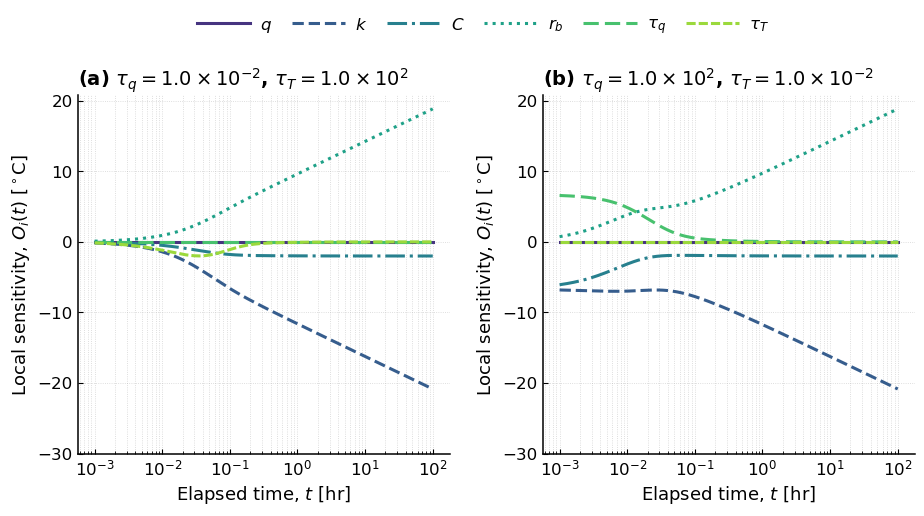

In [3]:
# ===== 顏色/線型（同前）與 colormap fallback =====
try:
    import cmcrameri as cmc
    cmap = cmc.batlow
except Exception:
    from matplotlib import cm
    cmap = cm.viridis

param_order = ['q','k','C','r_b','tau_q','tau_T']
color_list = [cmap(x) for x in np.linspace(0.15, 0.85, len(param_order))]
colors = {k: c for k, c in zip(param_order, color_list)}

linestyles = {
    'q':'-',
    'k':'--',
    'C':'-.',
    'r_b':':',
    'tau_q': (0, (5, 2)),
    'tau_T': (0, (3, 1)),
}
names_map = {'q':r'$q$', 'k':r'$k$', 'C':r'$C$',
             'r_b':r'$r_b$', 'tau_q':r'$\tau_q$', 'tau_T':r'$\tau_T$'}

# ===== 畫圖 =====
fig, axs = plt.subplots(1, 2, figsize=(10.8, 5.2), constrained_layout=False)
plt.subplots_adjust(top=0.80, wspace=0.25)  # 預留上方空白給共享圖例/標題

def plot_panel(ax, O, title_str):
    for key in param_order:
        ax.plot(t_h, O[key], color=colors[key], linestyle=linestyles[key], lw=2.2, label=names_map[key])
    ax.set_xscale('log')
    ax.set_xlabel(r'Elapsed time, $t$ [hr]', fontsize=13)
    ax.set_ylabel(r'Local sensitivity, $O_i(t)$ [$^\circ$C]', fontsize=13)
    ax.grid(True, which='both', ls=':', lw=0.6, alpha=0.55)
    ax.set_ylim(-30, None)
    # 標題固定在左上角
    ax.set_title(title_str, loc='left', fontsize=14, pad=6, fontweight='semibold')
    # 先加暫時 legend，等會兒抽把手
    ax.legend(frameon=False)

# 子圖標題
title_a = r'(a) $\tau_q=1.0\times10^{-2}$, $\tau_T=1.0\times10^{2}$'
title_b = r'(b) $\tau_q=1.0\times10^{2}$, $\tau_T=1.0\times10^{-2}$'
plot_panel(axs[0], O_A, title_a)
plot_panel(axs[1], O_B, title_b)

# ===== 共享圖例：放在整張圖的上方空白處（參數→顏色+線型 對照表）=====
# 取第一個子圖的圖例把手
handles, labels = axs[0].get_legend_handles_labels()
# 把各子圖內的 legend 拿掉（避免重複）
for ax in axs: 
    leg = ax.get_legend()
    if leg: leg.remove()

fig.legend(handles, labels,
           loc='upper center', bbox_to_anchor=(0.5, 0.98),
           ncol=6, frameon=False, fontsize=12,
           handlelength=3.2, columnspacing=1.2, handletextpad=0.6)

plt.show()
# plt.savefig('local_sensitivity_dual_lag_conference.png', dpi=300, bbox_inches='tight')


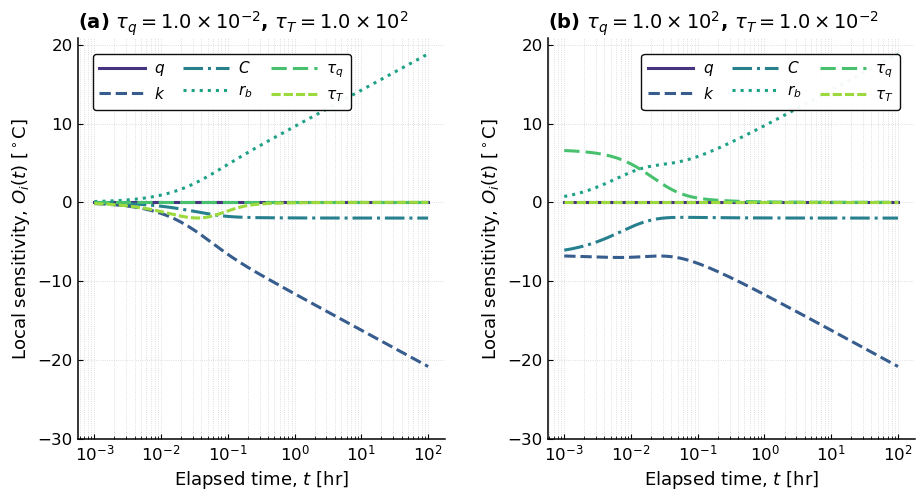

In [4]:
# ====================== Local sensitivity (time domain) — dual-lag TRT (conference style) ======================

import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.special import kv as besselk

# ---------- 視覺參數 ----------
plt.rcParams.update({
    "font.size": 12,
    "text.usetex": False,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.linewidth": 1.1,
    "xtick.direction": "in",
    "ytick.direction": "in",
})

# ---------- Stehfest inversion ----------
def stehfest_inversion(t, func, args, N=8):
    ln2 = np.log(2.0)
    def V(k):
        v = 0.0
        for j in range(int((k+1)/2), min(k, N//2)+1):
            num = j**(N//2) * math.factorial(2*j)
            den = (math.factorial(N//2-j)*math.factorial(j)*
                   math.factorial(j-1)*math.factorial(k-j)*math.factorial(2*j-k))
            v += num/den
        return v * (-1)**(k + N//2)
    return ln2/t * sum(V(k) * func(k*ln2/t, *args) for k in range(1, N+1))

# ---------- Laplace-domain solution ----------
#  T̄ = [ -q (1+s τ_q) / (k λ s (1+s τ_T)) ] * K0(λ r)/K1(λ r_b)
#  λ = sqrt( C s (1+s τ_q) / (k (1+s τ_T)) )
def T_bar_lag(r, s, tau_q, tau_T, q, k, C, r_b):
    lam = np.sqrt((C*s*(1.0 + s*tau_q)) / (k*(1.0 + s*tau_T)))
    K0, K1 = besselk(0, lam*r), besselk(1, lam*r_b)
    if (np.any(np.isnan([K0, K1])) or K1 == 0):
        return 0.0
    return (-q * (1.0 + s*tau_q) / (k * lam * s * (1.0 + s*tau_T))) * (K0 / K1)

def _F_lag(s, r, tau_q, tau_T, q, k, C, r_b):
    return T_bar_lag(r, s, tau_q, tau_T, q, k, C, r_b)

def T_lag(r, t, tau_q, tau_T, q, k, C, r_b, N=8):
    return stehfest_inversion(t, _F_lag, (r, tau_q, tau_T, q, k, C, r_b), N=N)

def T_series(params, t_s, N=8):
    r, q, k, C, r_b = params['r'], params['q'], params['k'], params['C'], params['r_b']
    tau_q, tau_T = params['tau_q'], params['tau_T']
    return np.array([T_lag(r, ti, tau_q, tau_T, q, k, C, r_b, N=N) for ti in t_s])

# ---------- Local sensitivity（central difference） ----------
def local_sensitivity(params, t_s, rel_step=1e-3, Ninv=8, names=None):
    if names is None:
        names = ['q','k','C','r_b','tau_q','tau_T']
    O = {}
    base = {k: params[k] for k in params}
    for key in names:
        p0 = base[key]
        p_plus  = max(p0 * (1.0 + rel_step), 1e-30)
        p_minus = max(p0 * (1.0 - rel_step), 1e-30)

        # +δ
        if key == 'r_b':
            params['r_b'] = p_plus; params['r'] = p_plus
        else:
            params[key] = p_plus; params['r'] = base['r']; params['r_b'] = base['r_b']
        T_plus = T_series(params, t_s, N=Ninv)

        # -δ
        if key == 'r_b':
            params['r_b'] = p_minus; params['r'] = p_minus
        else:
            params[key] = p_minus; params['r'] = base['r']; params['r_b'] = base['r_b']
        T_minus = T_series(params, t_s, N=Ninv)

        # 還原
        for k0 in base: params[k0] = base[k0]
        O[key] = (T_plus - T_minus) / (2.0 * rel_step)
    return O

# ---------- 時間軸 ----------
t_h = np.logspace(-3, 2, 220)           # 10^-3 ~ 10^2 hr
t_s = t_h * 3600.0

# ---------- 兩組參數 ----------
base_common = {
    'q'   : -50.0 * 3600.0**3,
    'k'   :  2.5  * 3600.0**3,
    'C'   :  2.0e6*3600.0**2,
    'r_b' :  0.2,
    'r'   :  0.2,
}
params_A = base_common | {'tau_q': 0.01, 'tau_T': 100}   # (a)
params_B = base_common | {'tau_q': 100,  'tau_T': 0.01}  # (b)

O_A = local_sensitivity(params_A.copy(), t_s)
O_B = local_sensitivity(params_B.copy(), t_s)

# ---------- colormap：batlow（fallback 到 viridis），取中段色階 ----------
try:
    import cmcrameri as cmc
    cmap = cmc.batlow
except Exception:
    from matplotlib import cm
    cmap = cm.viridis

param_order = ['q','k','C','r_b','tau_q','tau_T']
color_list = [cmap(x) for x in np.linspace(0.15, 0.85, len(param_order))]
colors = {k: c for k, c in zip(param_order, color_list)}

# ---------- 線型 ----------
linestyles = {
    'q'    : '-',
    'k'    : '--',
    'C'    : '-.',
    'r_b'  : ':',
    'tau_q': (0, (5, 2)),
    'tau_T': (0, (3, 1)),
}
names_map = {'q':r'$q$', 'k':r'$k$', 'C':r'$C$',
             'r_b':r'$r_b$', 'tau_q':r'$\tau_q$', 'tau_T':r'$\tau_T$'}

# ---------- 畫圖 ----------
fig, axs = plt.subplots(1, 2, figsize=(10.8, 5.2), constrained_layout=False)
plt.subplots_adjust(top=0.88, wspace=0.28)

def plot_panel(ax, O, title_str, legend_side="left"):
    for key in param_order:
        ax.plot(t_h, O[key], color=colors[key], linestyle=linestyles[key], lw=2.2, label=names_map[key])
    ax.set_xscale('log')
    ax.set_xlabel(r'Elapsed time, $t$ [hr]', fontsize=13)
    ax.set_ylabel(r'Local sensitivity, $O_i(t)$ [$^\circ$C]', fontsize=13)
    ax.grid(True, which='both', ls=':', lw=0.6, alpha=0.55)
    ax.set_ylim(-30, None)
    # 子圖標題：左上角
    ax.set_title(title_str, loc='left', fontsize=14, pad=6, fontweight='semibold')

    # ===== legend 放到圖內角落（黑框白底，不突兀）=====
    if legend_side == "left":
        loc, anchor = 'upper left', (0.02, 0.98)
    else:  # "right"
        loc, anchor = 'upper right', (0.98, 0.98)

    leg = ax.legend(ncol=3, fontsize=11, frameon=True,
                    handlelength=3.0, columnspacing=1.2, handletextpad=0.6,
                    loc=loc, bbox_to_anchor=anchor)
    # 美化 legend 外框
    leg.get_frame().set_edgecolor('black')
    leg.get_frame().set_linewidth(1.0)
    leg.get_frame().set_alpha(0.95)
    leg.get_frame().set_facecolor('white')

# (a), (b)
title_a = r'(a) $\tau_q=1.0\times10^{-2}$, $\tau_T=1.0\times10^{2}$'
title_b = r'(b) $\tau_q=1.0\times10^{2}$, $\tau_T=1.0\times10^{-2}$'
plot_panel(axs[0], O_A, title_a, legend_side="left")   # 左上角
plot_panel(axs[1], O_B, title_b, legend_side="right")  # 右上角

plt.show()
# plt.savefig('local_sensitivity_dual_lag_conference.png', dpi=300, bbox_inches='tight')


In [ ]:
# ========= Fast & Stable TRT inversion: Dual-lag vs ILS (with weighting, warm-start) =========
import numpy as np, math, pandas as pd
import matplotlib.pyplot as plt
from scipy.special import kv as besselk
from scipy.optimize import differential_evolution, least_squares

# ---------- style ----------
plt.rcParams.update({
    "font.size": 13, "text.usetex": False,
    "axes.spines.top": False, "axes.spines.right": False,
    "axes.linewidth": 1.2, "xtick.direction": "in", "ytick.direction": "in"
})

# ---------- Stehfest with precomputed coeffs ----------
def stehfest_inversion(t, func, args, N=8):
    ln2 = np.log(2.0)
    V = np.empty(N)
    for k in range(1, N+1):
        v = 0.0
        for j in range(int((k+1)/2), min(k, N//2)+1):
            num = j**(N//2) * math.factorial(2*j)
            den = (math.factorial(N//2-j)*math.factorial(j)*
                   math.factorial(j-1)*math.factorial(k-j)*math.factorial(2*j-k))
            v += num/den
        V[k-1] = v * (-1)**(k + N//2)
    sk = (np.arange(1, N+1) * ln2) / t
    F = np.array([func(s, *args) for s in sk])
    return (ln2/t) * np.dot(V, F)

# ---------- Dual-lag forward ----------
def Tbar_duallag(r, s, tau_q, tau_T, q, k, C, r_b):
    lam = np.sqrt((C*s*(1.0 + s*tau_q)) / (k*(1.0 + s*tau_T)))
    K0, K1 = besselk(0, lam*r), besselk(1, lam*r_b)
    if (np.any(np.isnan([K0, K1])) or K1 == 0): return 0.0
    return (-q * (1.0 + s*tau_q) / (k * lam * s * (1.0 + s*tau_T))) * (K0 / K1)

def _F_duallag(s, r, tau_q, tau_T, q, k, C, r_b):
    return Tbar_duallag(r, s, tau_q, tau_T, q, k, C, r_b)

def T_duallag_time(r, t, tau_q, tau_T, q, k, C, r_b, N=8):
    return stehfest_inversion(t, _F_duallag, (r, tau_q, tau_T, q, k, C, r_b), N=N)

def predict_duallag(t_s, pars, Ninvert=8):
    r, q, k, C, r_b, tau_q_s, tau_T_s = pars
    return np.array([T_duallag_time(r, ti, tau_q_s, tau_T_s, q, k, C, r_b, N=Ninvert) for ti in t_s])

# ---------- ILS ----------
def predict_ILS(t_s, pars):
    r, q, k, C, r_b = pars
    alpha = k / C
    return (-q/(4*np.pi*k)) * (np.log(4*alpha*t_s/r_b**2) - 0.5772156649)

# ---------- load data & ΔT ----------
df = pd.read_excel("Field data.xlsx")
t_hr = df["Time"].to_numpy(float)
T_obs = df["Temperature"].to_numpy(float)
dT_obs = T_obs - T_obs[0]
t_s = t_hr * 3600.0

fixed = {'r':0.2, 'r_b':0.2}

# ---------- log-bin weights（平衡早/晚期） ----------
def logbin_weights(t_s, nbins=18):
    edges = np.geomspace(t_s.min(), t_s.max(), nbins+1)
    idx = np.searchsorted(edges, t_s, side='right') - 1
    idx = np.clip(idx, 0, nbins-1)
    counts = np.bincount(idx, minlength=nbins)
    w = 1.0 / counts[idx]
    return w / w.mean()

w_full = logbin_weights(t_s, nbins=18)

# ---------- coarse subset for fast DE ----------
def coarse_mask(t_s, n=36):
    target = np.geomspace(t_s.min(), t_s.max(), n)
    idx = np.searchsorted(t_s, target)
    idx = np.clip(idx, 0, len(t_s)-1)
    return np.unique(idx)

mask_c = coarse_mask(t_s, n=36)
t_s_c, dT_c, w_c = t_s[mask_c], dT_obs[mask_c], w_full[mask_c]

# ---------- bounds ----------
b_dual = [(0.5,5.0), (0.8e6,5.0e6), (1e-3,20.0), (1e-3,20.0), (-300.0,-10.0)]  # τ上限收窄→更穩
b_ils  = [(0.5,5.0), (0.8e6,5.0e6), (-300.0,-10.0)]

# ---------- objectives (weighted) ----------
def resid_dual_w(x, t, y, w):
    k, C, tauq_h, tauT_h, q = x
    y_sim = predict_duallag(t, (fixed['r'], q, k, C, fixed['r_b'], tauq_h*3600, tauT_h*3600))
    return (y_sim - y) * np.sqrt(w)

def resid_ils_w(x, t, y, w):
    k, C, q = x
    y_sim = predict_ILS(t, (fixed['r'], q, k, C, fixed['r_b']))
    return (y_sim - y) * np.sqrt(w)

def obj_dual_c(x): return float(np.dot(risd := resid_dual_w(x, t_s_c, dT_c, w_c), risd))
def obj_ils_c(x):  return float(np.dot(ris := resid_ils_w(x,  t_s_c, dT_c, w_c), ris))

# ---------- DE（coarse, 多核心, 非同步） + LS（full, weighted） ----------
resD = differential_evolution(obj_dual_c, b_dual, workers=-1, updating='deferred',
                              popsize=14, maxiter=80, mutation=(0.3,0.9), recombination=0.65,
                              tol=1e-4, seed=42)
locD = least_squares(resid_dual_w, x0=resD.x, bounds=np.array(list(zip(*b_dual))).T,
                     args=(t_s, dT_obs, w_full), method='trf', max_nfev=3000)
kD, CD, tauq_hD, tauT_hD, qD = locD.x
y_dual = predict_duallag(t_s, (fixed['r'], qD, kD, CD, fixed['r_b'], tauq_hD*3600, tauT_hD*3600))
rmseD = np.sqrt(np.mean((y_dual - dT_obs)**2))

resI = differential_evolution(obj_ils_c, b_ils, workers=-1, updating='deferred',
                              popsize=12, maxiter=60, mutation=(0.3,0.9), recombination=0.65,
                              tol=1e-4, seed=7)
locI = least_squares(resid_ils_w, x0=resI.x, bounds=np.array(list(zip(*b_ils))).T,
                     args=(t_s, dT_obs, w_full), method='trf', max_nfev=2000)
kI, CI, qI = locI.x
y_ils = predict_ILS(t_s, (fixed['r'], qI, kI, CI, fixed['r_b']))
rmseI = np.sqrt(np.mean((y_ils - dT_obs)**2))

# ---------- truncation test（warm-start，超平順） ----------
tmax_list_hr = np.arange(12, 73, 6)
hist = []
x_prev = locD.x.copy()  # 用 full-record 的 LS 結果當起點
for tmax in tmax_list_hr:
    m = (t_hr <= tmax)
    if m.sum()<8: continue
    # 直接做 LS（權重用對應子集合），避免每步都跑 DE
    w_sub = logbin_weights(t_s[m], nbins=14)
    loc = least_squares(resid_dual_w, x0=x_prev, bounds=np.array(list(zip(*b_dual))).T,
                        args=(t_s[m], dT_obs[m], w_sub), method='trf', max_nfev=1500)
    x_prev = loc.x.copy()
    k_,C_,tq_,tT_,q_ = x_prev
    hist.append((tmax, k_, C_, tq_, tT_, q_))
hist = np.array(hist) if len(hist) else np.zeros((0,6))

# ---------- table ----------
tbl = pd.DataFrame([
    ["ILS",      kI, CI, np.nan, np.nan, qI, rmseI],
    ["Dual-lag", kD, CD, tauq_hD, tauT_hD, qD, rmseD],
], columns=["Model","k (W/m·K)","C (J/m³·K)","τq (h)","τT (h)","q (W/m)","RMSE (°C)"])
print("\nEstimated parameters (weighted, warm-start)\n" + tbl.to_string(index=False))

# ---------- colors ----------
try:
    import cmcrameri as cmc; cmap = cmc.batlow
except Exception:
    from matplotlib import cm; cmap = cm.viridis
c_dual = cmap(0.70)

# ---------- FIG A：linear & semi-log ----------
fig, axs = plt.subplots(1, 2, figsize=(10.6, 4.8))
for ax in axs:
    ax.plot(t_hr, dT_obs, 'o', ms=3.0, color="black", alpha=0.85, label="TRT data")
    ax.plot(t_hr, y_dual, color=c_dual, lw=2.4, label="Dual-lag fit")
    ax.plot(t_hr, y_ils,  color="dimgray", lw=2.0, ls='--', label="ILS fit")
    ax.set_xlabel("Elapsed time, t [hr]"); ax.set_ylabel(r"$\Delta T(r_b,t)$ [°C]")
    ax.legend(loc='lower right', frameon=True)
axs[1].set_xscale('log')
for ax in axs:
    for sp in ax.spines.values(): sp.set_edgecolor('black'); sp.set_linewidth(1.2)
fig.patch.set_edgecolor('black'); fig.patch.set_linewidth(2.0)
plt.tight_layout(); plt.show()

# ---------- FIG B：convergence（k, C, τq, τT） ----------
if hist.size:
    fig, axs = plt.subplots(2, 2, figsize=(9.6, 6.0), sharex=True)
    labels = [("k (W/m·K)",1), ("C (J/m³·K)",2), (r"$\tau_q$ [h]",3), (r"$\tau_T$ [h]",4)]
    for ax,(lab,idx) in zip(axs.ravel(), labels):
        ax.plot(hist[:,0], hist[:,idx], '-o', ms=3.2, lw=2.0, color=cmap(0.60))
        ax.set_ylabel(lab); ax.grid(False)
        for sp in ax.spines.values(): sp.set_edgecolor('black'); sp.set_linewidth(1.1)
    axs[1,0].set_xlabel("tmax used [hr]"); axs[1,1].set_xlabel("tmax used [hr]")
    fig.patch.set_edgecolor('black'); fig.patch.set_linewidth(2.0)
    plt.tight_layout(); plt.show()


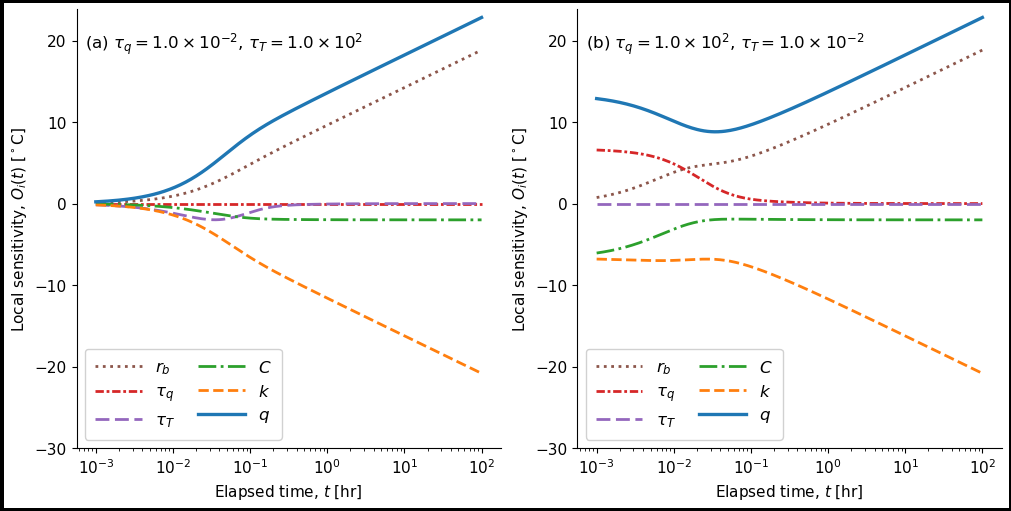

In [23]:
# ====================== Local sensitivity (time domain) — dual-lag TRT ======================
# (a) (b) 標題依照 tau_q, tau_T；全圖黑色外框；Early/Mid/Late 對齊 10^-1, 10^0, 10^1, 10^2

import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.special import kv as besselk

plt.rcParams.update({
    "font.size": 11,
    "text.usetex": False,          # 若電腦沒裝 LaTeX，False 比較穩；標籤仍用 TeX 語法
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# ---------- Stehfest inversion ----------
def stehfest_inversion(t, func, args, N=8):
    ln2 = np.log(2.0)
    def V(k):
        v = 0.0
        for j in range(int((k+1)/2), min(k, N//2)+1):
            num = j**(N//2) * math.factorial(2*j)
            den = (math.factorial(N//2-j)*math.factorial(j)*
                   math.factorial(j-1)*math.factorial(k-j)*math.factorial(2*j-k))
            v += num/den
        return v * (-1)**(k + N//2)
    return ln2/t * sum(V(k) * func(k*ln2/t, *args) for k in range(1, N+1))

# ---------- Dual-lag Laplace-domain solution ----------
#  T̄ = [ -q (1+s τ_q) / (k λ s (1+s τ_T)) ] * K0(λ r)/K1(λ r_b),  λ = sqrt( C s (1+s τ_q) / (k (1+s τ_T)) )
def T_bar_lag(r, s, tau_q, tau_T, q, k, C, r_b):
    lam = np.sqrt((C*s*(1.0 + s*tau_q)) / (k*(1.0 + s*tau_T)))
    K0, K1 = besselk(0, lam*r), besselk(1, lam*r_b)
    if (np.any(np.isnan([K0, K1])) or K1 == 0):
        return 0.0
    return (-q * (1.0 + s*tau_q) / (k * lam * s * (1.0 + s*tau_T))) * (K0 / K1)

def _F_lag(s, r, tau_q, tau_T, q, k, C, r_b):
    return T_bar_lag(r, s, tau_q, tau_T, q, k, C, r_b)

def T_lag(r, t, tau_q, tau_T, q, k, C, r_b, N=8):
    return stehfest_inversion(t, _F_lag, (r, tau_q, tau_T, q, k, C, r_b), N=N)

def T_series(params, t_s, N=8):
    r, q, k, C, r_b = params['r'], params['q'], params['k'], params['C'], params['r_b']
    tau_q, tau_T = params['tau_q'], params['tau_T']
    return np.array([T_lag(r, ti, tau_q, tau_T, q, k, C, r_b, N=N) for ti in t_s])

# ---------- Local sensitivity（central difference, relative step δ） ----------
def local_sensitivity(params, t_s, rel_step=1e-3, Ninv=8, names=None):
    if names is None:
        names = ['q','k','C','r_b','tau_q','tau_T']

    T0 = T_series(params, t_s, N=Ninv)
    T_safe = np.where(np.abs(T0) < 1e-12, 1e-12, T0)   # 目前沒用到，但保留

    O = {}
    base = {k: params[k] for k in params}

    for key in names:
        p0 = base[key]
        p_plus  = p0 * (1.0 + rel_step)
        p_minus = p0 * (1.0 - rel_step)
        if key in ('k','C','tau_q','tau_T','r_b'):
            p_plus  = max(p_plus,  1e-30)
            p_minus = max(p_minus, 1e-30)

        # +δ
        if key == 'r_b':
            params['r_b'] = p_plus
            params['r']   = p_plus
        else:
            params[key]   = p_plus
            params['r']   = base['r']
            params['r_b'] = base['r_b']
        T_plus = T_series(params, t_s, N=Ninv)

        # -δ
        if key == 'r_b':
            params['r_b'] = p_minus
            params['r']   = p_minus
        else:
            params[key]   = p_minus
            params['r']   = base['r']
            params['r_b'] = base['r_b']
        T_minus = T_series(params, t_s, N=Ninv)

        # 還原
        for k0 in base:
            params[k0] = base[k0]

        O[key] = (T_plus - T_minus) / (2.0 * rel_step)

    return T0, O

# ---------- 時間軸（hr / s） ----------
t_h = np.logspace(-3, 2, 220)       # 10^-3 ~ 10^2 hr
t_s = t_h * 3600.0

# ---------- 兩組參數：Baseline 與 Swap ----------
base_common = {
    'q'    : -50.0 * 3600.0**3,
    'k'    :  2.5  * 3600.0**3,
    'C'    :  2.0e6* 3600.0**2,
    'r_b'  :  0.2,
    'r'    :  0.2,
}
params_A = base_common | {'tau_q': 0.01, 'tau_T': 100}   # (a)
params_B = base_common | {'tau_q': 100,  'tau_T': 0.01}  # (b)

# ---------- 計算局部敏感度 ----------
_, O_A = local_sensitivity(params_A.copy(), t_s, rel_step=1e-3, Ninv=8)
_, O_B = local_sensitivity(params_B.copy(), t_s, rel_step=1e-3, Ninv=8)

# ---------- 顏色、線型、zorder、標籤 ----------
# 顏色：保留老師原色（你也可切換 batlow）
colors = {
    'q':'#1f77b4',   'k':'#ff7f0e',  'C':'#2ca02c',
    'r_b':'#8c564b', 'tau_q':'#d62728','tau_T':'#9467bd'
}
# 六條線給六種 *醒目* 線型（避免看起來都像破折）
linestyles = {
    'q':'-',                         # 實線
    'k':'--',                        # 長虛線
    'C':'-.',                        # 點畫線
    'r_b':':',                       # 點線
    'tau_q':(0,(3,1,1,1)),           # dash-dot-dot
    'tau_T':(0,(5,2))                # 自訂長短破折
}
# 繪圖順序與層級：把 q 放最後畫、zorder 最高，避免被蓋住
draw_order = ['r_b','tau_q','tau_T','C','k','q']
zorder_map = {'r_b':1, 'tau_q':1, 'tau_T':1, 'C':2, 'k':3, 'q':5}

names_map = {'q':r'$q$', 'k':r'$k$', 'C':r'$C$',
             'r_b':r'$r_b$', 'tau_q':r'$\tau_q$', 'tau_T':r'$\tau_T$'}

# ---------- 畫圖 ----------
fig, axs = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

def plot_panel(ax, O, title_str):
    for key in draw_order:
        ax.plot(t_h, O[key],
                color=colors[key],
                ls=linestyles[key],
                lw=2.4 if key=='q' else 2.0,    # q 稍微加粗
                zorder=zorder_map[key],
                label=names_map[key])
    ax.set_xscale('log')
    ax.set_xlabel(r'Elapsed time, $t$ [hr]')
    ax.set_ylabel(r'Local sensitivity, $O_i(t)$ [$^\circ$C]')
    ax.legend(ncol=2, loc='lower left', fontsize=12,
              frameon=True, facecolor='white', framealpha=0.9,
              handlelength=2.8, handletextpad=0.8, columnspacing=1.4, borderpad=0.6)
    ax.text(0.02, 0.95, title_str, transform=ax.transAxes, ha="left", va="top", fontsize=12)
    # 自動上下界 + 餘裕，讓線不貼邊
    ymin = min(np.min(O[k]) for k in O); ymax = max(np.max(O[k]) for k in O)
    ax.set_ylim(ymin-1, ymax+1)
    ax.set_ylim(-30,None)
# (a) 與 (b) 標題（LaTeX 參數）
title_a = r'(a) $\tau_q=1.0\times10^{-2}$, $\tau_T=1.0\times10^{2}$'
title_b = r'(b) $\tau_q=1.0\times10^{2}$, $\tau_T=1.0\times10^{-2}$'

plot_panel(axs[0], O_A, title_a)
plot_panel(axs[1], O_B, title_b)

# 外框黑框（整張圖）
fig.patch.set_edgecolor('black')
fig.patch.set_linewidth(5.0)

plt.show()


In [ ]:

import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from scipy.special import kv as besselk  # Modified Bessel Kν

# --- optional colormap: cmcrameri.batlow ---
try:
    import cmcrameri.cm as cmc      # pip install cmcrameri
    cmap = cmc.batlow
except Exception:
    cmap = plt.get_cmap('viridis')

plt.rcParams.update({
    "font.size": 11,
    "text.usetex": False,      # 不要求系統 LaTeX；數學式用 mathtext
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# ---------- Stehfest 數值逆拉 (N 必須偶數) ----------
def stehfest_inversion(t, func, args, N=8):
    ln2 = np.log(2.0)
    def V(k):
        v = 0.0
        for j in range(int((k+1)/2), min(k, N//2)+1):
            num = j**(N//2) * math.factorial(2*j)
            den = (math.factorial(N//2-j)*math.factorial(j)*
                   math.factorial(j-1)*math.factorial(k-j)*math.factorial(2*j-k))
            v += num/den
        return v * (-1)**(k + N//2)
    t = float(t)
    return ln2/t * sum(V(k) * func(k*ln2/t, *args) for k in range(1, N+1))

# ---------- 拉氏域解（Dual-lag / Fourier）----------
# T̄ = [ -q (1+s τ_q) / (k λ s (1+s τ_T)) ] * K0(λ r)/K1(λ r_b)
# λ  = sqrt( C s (1+s τ_q) / (k (1+s τ_T)) )
def T_bar_lag(r, s, tau_q, tau_T, q, k, C, r_b):
    lam = np.sqrt((C*s*(1.0 + s*tau_q)) / (k*(1.0 + s*tau_T)))
    K0, K1 = besselk(0, lam*r), besselk(1, lam*r_b)
    if (np.any(np.isnan([K0, K1])) or K1 == 0):
        return 0.0
    return (-q * (1.0 + s*tau_q) / (k * lam * s * (1.0 + s*tau_T))) * (K0 / K1)

def T_bar_fourier(r, s, q, k, C, r_b):
    lam = np.sqrt(C*s/k)
    K0, K1 = besselk(0, lam*r), besselk(1, lam*r_b)
    if (np.any(np.isnan([K0, K1])) or K1 == 0):
        return 0.0
    return (-q / (k * lam * s)) * (K0 / K1)

def _F_lag(s, r, tau_q, tau_T, q, k, C, r_b):  return T_bar_lag(r, s, tau_q, tau_T, q, k, C, r_b)
def _F_fourier(s, r, q, k, C, r_b):           return T_bar_fourier(r, s, q, k, C, r_b)

# 時間域解（t, τ 以秒輸入；輸出為 ΔT [°C]）
def T_lag(r, t, tau_q, tau_T, q, k, C, r_b, N=8):
    return stehfest_inversion(t, _F_lag,     (r, tau_q, tau_T, q, k, C, r_b), N=N)
def T_fourier(r, t, q, k, C, r_b, N=8):
    return stehfest_inversion(t, _F_fourier, (r, q, k, C, r_b), N=N)

# ---------- 物理參數（與你先前設定一致） ----------
r, r_b = 0.2, 0.2
q = -50.0 * 3600.0**3             # W/m
k =   2.5 * 3600.0**3             # W/m/K
C = 2.0e6 * 3600.0**2             # J/m³/K

# 時間（有因次，hr），畫 0.1 ~ 120 小時
t_h = np.logspace(-3, 2.08, 190)  # 0.1 ~ ≈120 hr
t_s = t_h * 3600.0

# ---------- 作圖公用：算溫度序列 ----------
def T_series_lag_hours(tau_q_h, tau_T_h, Ninv=8):
    tq = tau_q_h * 3600.0
    tT = tau_T_h * 3600.0
    return np.array([T_lag(r, ti, tq, tT, q, k, C, r_b, N=Ninv) for ti in t_s])

def T_series_ils():
    return np.array([T_fourier(r, ti, q, k, C, r_b, N=8) for ti in t_s])

# ---------- Panel (a): 固定 tau_q=30h，掃 tau_T=20/40/50h ----------
tau_q_fixed_a = 1.0
tau_T_list_a  = [1.0, 5.0, 10.0, 15, 20]
linestyles = ['-', '--', ':', '-.']  # 對應三個變動值

# ---------- Panel (b): 固定 tau_T=30h，掃 tau_q=20/40/50h ----------
tau_T_fixed_b = 1.0
tau_q_list_b  = [1.0, 5.0, 10.0, 15, 20]

# 固定參數顏色（兩張圖各一色，出自 batlow 漸層）
color_a = cmap(0.65)    # (a) 用一個色
color_b = cmap(0.30)    # (b) 用另一個色



In [1]:
# ====================== Dual-lag TRT — dimensional (hours, °C) ======================
# (a) 固定 tau_q=30 h，掃 tau_T ∈ {20, 40, 50} h（線型）
# (b) 固定 tau_T=30 h，掃 tau_q ∈ {20, 40, 50} h（線型）
# 兩圖皆加入 ILS（τ=0）黑色基準線；顏色使用 cmcrameri.batlow（若無則退回 viridis）
# 圖例置於圖內；整張圖黑色外框；標題含 (a)(b) 與參數設定

import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from scipy.special import kv as besselk  # Modified Bessel Kν

# --- optional colormap: cmcrameri.batlow ---
try:
    import cmcrameri.cm as cmc      # pip install cmcrameri
    cmap = cmc.batlow
except Exception:
    cmap = plt.get_cmap('viridis')

plt.rcParams.update({
    "font.size": 11,
    "text.usetex": False,      # 不要求系統 LaTeX；數學式用 mathtext
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# ---------- Stehfest 數值逆拉 (N 必須偶數) ----------
def stehfest_inversion(t, func, args, N=8):
    ln2 = np.log(2.0)
    def V(k):
        v = 0.0
        for j in range(int((k+1)/2), min(k, N//2)+1):
            num = j**(N//2) * math.factorial(2*j)
            den = (math.factorial(N//2-j)*math.factorial(j)*
                   math.factorial(j-1)*math.factorial(k-j)*math.factorial(2*j-k))
            v += num/den
        return v * (-1)**(k + N//2)
    t = float(t)
    return ln2/t * sum(V(k) * func(k*ln2/t, *args) for k in range(1, N+1))

# ---------- 拉氏域解（Dual-lag / Fourier）----------
# T̄ = [ -q (1+s τ_q) / (k λ s (1+s τ_T)) ] * K0(λ r)/K1(λ r_b)
# λ  = sqrt( C s (1+s τ_q) / (k (1+s τ_T)) )
def T_bar_lag(r, s, tau_q, tau_T, q, k, C, r_b):
    lam = np.sqrt((C*s*(1.0 + s*tau_q)) / (k*(1.0 + s*tau_T)))
    K0, K1 = besselk(0, lam*r), besselk(1, lam*r_b)
    if (np.any(np.isnan([K0, K1])) or K1 == 0):
        return 0.0
    return (-q * (1.0 + s*tau_q) / (k * lam * s * (1.0 + s*tau_T))) * (K0 / K1)

def T_bar_fourier(r, s, q, k, C, r_b):
    lam = np.sqrt(C*s/k)
    K0, K1 = besselk(0, lam*r), besselk(1, lam*r_b)
    if (np.any(np.isnan([K0, K1])) or K1 == 0):
        return 0.0
    return (-q / (k * lam * s)) * (K0 / K1)

def _F_lag(s, r, tau_q, tau_T, q, k, C, r_b):  return T_bar_lag(r, s, tau_q, tau_T, q, k, C, r_b)
def _F_fourier(s, r, q, k, C, r_b):           return T_bar_fourier(r, s, q, k, C, r_b)

# 時間域解（t, τ 以秒輸入；輸出為 ΔT [°C]）
def T_lag(r, t, tau_q, tau_T, q, k, C, r_b, N=8):
    return stehfest_inversion(t, _F_lag,     (r, tau_q, tau_T, q, k, C, r_b), N=N)
def T_fourier(r, t, q, k, C, r_b, N=8):
    return stehfest_inversion(t, _F_fourier, (r, q, k, C, r_b), N=N)

# ---------- 物理參數（與你先前設定一致） ----------
r, r_b = 0.2, 0.2
q = -50.0 * 3600.0**3             # W/m
k =   2.5 * 3600.0**3             # W/m/K
C = 2.0e6 * 3600.0**2             # J/m³/K

# 時間（有因次，hr），畫 0.1 ~ 120 小時
t_h = np.logspace(-3, 2.08, 190)  # 0.1 ~ ≈120 hr
t_s = t_h * 3600.0

# ---------- 作圖公用：算溫度序列 ----------
def T_series_lag_hours(tau_q_h, tau_T_h, Ninv=8):
    tq = tau_q_h * 3600.0
    tT = tau_T_h * 3600.0
    return np.array([T_lag(r, ti, tq, tT, q, k, C, r_b, N=Ninv) for ti in t_s])

def T_series_ils():
    return np.array([T_fourier(r, ti, q, k, C, r_b, N=8) for ti in t_s])

# ---------- Panel (a): 固定 tau_q=30h，掃 tau_T=20/40/50h ----------
tau_q_fixed_a = 1.0
tau_T_list_a  = [1.0, 5.0, 10.0, 15, 20]
linestyles = ['-', '--', ':', '-.']  # 對應三個變動值

# ---------- Panel (b): 固定 tau_T=30h，掃 tau_q=20/40/50h ----------
tau_T_fixed_b = 1.0
tau_q_list_b  = [1.0, 5.0, 10.0, 15, 20]

# 固定參數顏色（兩張圖各一色，出自 batlow 漸層）
color_a = cmap(0.65)    # (a) 用一個色
color_b = cmap(0.30)    # (b) 用另一個色




<>:15: SyntaxWarning: invalid escape sequence '\ '
<>:33: SyntaxWarning: invalid escape sequence '\ '
<>:15: SyntaxWarning: invalid escape sequence '\ '
<>:33: SyntaxWarning: invalid escape sequence '\ '
C:\Users\LIN\AppData\Local\Temp\ipykernel_14208\4282891564.py:15: SyntaxWarning: invalid escape sequence '\ '
  ax.text(0.02, 0.95, "(a) $\\tau_q=1\ \mathrm{h}$", transform=ax.transAxes, ha="left", va="top", fontsize=16)
C:\Users\LIN\AppData\Local\Temp\ipykernel_14208\4282891564.py:33: SyntaxWarning: invalid escape sequence '\ '
  ax.text(0.02, 0.95, "(b) $\\tau_T=1\ \mathrm{h}$", transform=ax.transAxes, ha="left", va="top", fontsize=16)


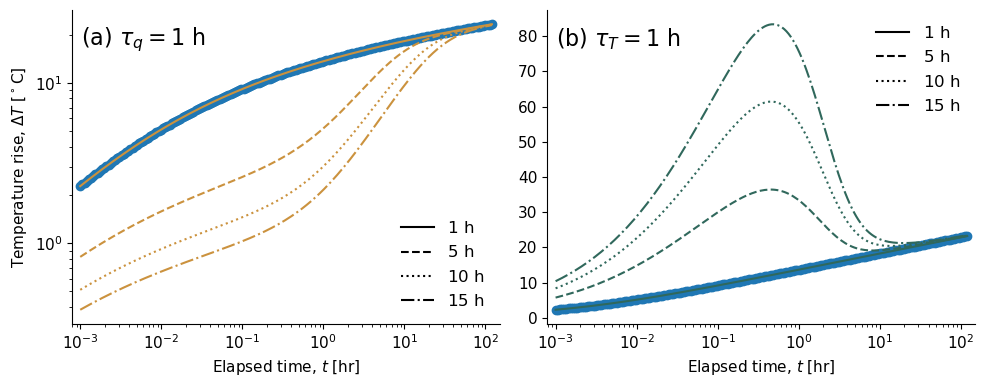

In [2]:
# ---------- 畫圖 ----------
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=False)

def plot_panel_a(ax):
    # ILS baseline
    ax.plot(t_h, T_series_ils(), 'o', label='ILS')
    # 固定 tau_q 顏色；不同 tau_T 用線型
    for ls, tau_T_h in zip(linestyles, tau_T_list_a):
        Tvals = T_series_lag_hours(tau_q_fixed_a, tau_T_h)
        ax.plot(t_h, Tvals, color=color_a, ls=ls, lw=1.5)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel(r'Elapsed time, $t$ [hr]')
    ax.set_ylabel(r'Temperature rise, $\Delta T$ [$^\circ$C]')
    ax.text(0.02, 0.95, "(a) $\\tau_q=1\ \mathrm{h}$", transform=ax.transAxes, ha="left", va="top", fontsize=16)
    # 內嵌圖例（顏色→固定，線型→變動）
    color_handles = [Line2D([0],[0], color=color_a, lw=1.5)]

    style_handles = [Line2D([0],[0], color='k', lw=1.5, ls=ls) for ls in linestyles]
    style_labels  = [r'$1\ \mathrm{h}$', r'$5\ \mathrm{h}$', r'$10\ \mathrm{h}$', r'$15\ \mathrm{h}$']
    ax.legend(style_handles, style_labels,
              loc='lower right', 
              frameon=False, fontsize=12)
def plot_panel_b(ax):
    ax.plot(t_h, T_series_ils(), 'o', label='ILS')
    for ls, tau_q_h in zip(linestyles, tau_q_list_b):
        Tvals = T_series_lag_hours(tau_q_h, tau_T_fixed_b)
        ax.plot(t_h, Tvals, color=color_b, ls=ls, lw=1.5)

    ax.set_xscale('log')
    ax.set_xlabel(r'Elapsed time, $t$ [hr]')

    ax.text(0.02, 0.95, "(b) $\\tau_T=1\ \mathrm{h}$", transform=ax.transAxes, ha="left", va="top", fontsize=16)

    color_handles = [Line2D([0],[0], color=color_b, lw=1.5)]

    style_handles = [Line2D([0],[0], color='k', lw=1.5, ls=ls) for ls in linestyles]
    style_labels  = [r'$1\ \mathrm{h}$', r'$5\ \mathrm{h}$', r'$10\ \mathrm{h}$', r'$15\ \mathrm{h}$']
    ax.legend(style_handles, style_labels,
              loc='upper right', 
              frameon=False, fontsize=12)

plot_panel_a(axes[0])
plot_panel_b(axes[1])

# 微調網格與留白
for ax in axes:    # 讓曲線更貼近邊界（避免多餘留白）
    ax.margins(x=0.02)

plt.tight_layout()
plt.show()


In [ ]:
# ================== TRT parameter estimation (Dual-lag; q fixed; t in hr) ==================
# 只估 k, C, tau_q[h], tau_T[h]，q 固定；先 ILS 起點 → TRF（trust-region reflective）微調
# Excel 檔：Field data.xlsx，欄位：Time [hr], Temperature [°C]

import numpy as np, pandas as pd, math, matplotlib.pyplot as plt, time
from pathlib import Path
from scipy.special import kv as besselk
from scipy.optimize import least_squares

# ------------------------- 使用者設定 -------------------------
FILE      = "Field data.xlsx"     # Excel 檔名
COL_TIME  = "Time"                # 時間欄 (hr)
COL_TEMP  = "Temperature"         # 溫度欄 (°C)

Q_W_PER_M = -70.0                 # 固定 q [W/m]；加熱→負號（若與斜率不符，程式會自動翻轉一次）
R_BORE    = 0.2                   # 井半徑 [m]
R_EVAL    = R_BORE                # 評估半徑 r [m]

# —— 加速旋鈕（需要更快就往小改）——
N_STEHFEST = 6                    # Stehfest 階數：6 (快且穩)；4 (更快)；8 (較慢)
FIT_POINTS = 60                   # 擬合用的對數下採樣點數（畫圖仍用全資料）
FIT_RANGE  = None                 # 例：(0.2, 60) 只擬合 0.2–60 hr；None 表全域
MAX_NFEV   = 800                  # 最多函數評估次數（可調 300–800）

# ---------------------- 讀檔與資料前處理 ----------------------
df = pd.read_excel(FILE, engine="openpyxl")
assert {COL_TIME, COL_TEMP}.issubset(df.columns), "Excel 需含欄位 Time, Temperature"
t_hr  = df[COL_TIME].astype(float).to_numpy()
Tobs  = df[COL_TEMP].astype(float).to_numpy()
ordr  = np.argsort(t_hr); t_hr, Tobs = t_hr[ordr], Tobs[ordr]
dTobs = Tobs - Tobs[0]

# 若 Excel 內有 q 欄可覆寫（可省下手動輸入）
for key in ["q","Q","q_Wm","Q_Wm"]:
    if key in df.columns:
        Q_W_PER_M = float(df[key].iloc[0]); break

# 可選擇擬合視窗（通常 0.2–60 hr 會更穩）
if FIT_RANGE is not None:
    tmin, tmax = FIT_RANGE
    sel = (t_hr >= tmin) & (t_hr <= tmax)
    t_fit_full, y_fit_full = t_hr[sel], dTobs[sel]
else:
    t_fit_full, y_fit_full = t_hr, dTobs

# ---------------------- ILS 快估（閉式解） ----------------------
gamma = 0.5772156649
mask_late = t_hr >= np.percentile(t_hr, 70)                 # 取後 30% 當晚期
A, B = np.polyfit(np.log(t_hr[mask_late]), dTobs[mask_late], 1)   # ΔT ≈ A ln t + B

# 自動修正 q 符號（避免走錯方向）
if (A > 0 and Q_W_PER_M > 0) or (A < 0 and Q_W_PER_M < 0):
    Q_W_PER_M = -Q_W_PER_M

# k0, C0 seed（時間用 hr；k in W/m/K；C in J/m^3/K）
k0 = - Q_W_PER_M / (4*np.pi*A)
C0 = (4*k0)/(R_BORE**2) * np.exp( - (4*np.pi*k0/Q_W_PER_M)*B + gamma )
k0 = float(np.clip(k0, 0.6, 4.0))
C0 = float(np.clip(C0, 0.8e6, 4.0e6))
tq0, tT0 = 0.2, 1.0   # 小時級合理起點

# ---------------------- Stehfest 反演（hr 量綱） ----------------------
LN2, N_STE = np.log(2.0), N_STEHFEST
def _stehfest_coeff(N=N_STE):
    V = np.empty(N)
    for k in range(1, N+1):
        v = 0.0
        for j in range((k+1)//2, min(k, N//2)+1):
            num = j**(N//2) * math.factorial(2*j)
            den = (math.factorial(N//2-j)*math.factorial(j)*
                   math.factorial(j-1)*math.factorial(k-j)*math.factorial(2*j-k))
            v += num/den
        V[k-1] = v * (-1)**(k + N//2)
    return V
VSTE = _stehfest_coeff()

def _stehfest_inv_hr(t, F, args):
    s = (np.arange(1, N_STE+1)*LN2)/t     # s 單位：1/hr
    vals = np.array([F(si, *args) for si in s])
    return (LN2/t) * np.dot(VSTE, vals)

# 拉氏域雙延遲：t, τ（hr）；k, q 轉為「每小時能量」以與 s 相容
def _Tbar_duallag_hr(r, s, tau_q_h, tau_T_h, q_Wm, k_WmK, C, r_b):
    H = 3600.0
    k_hr, q_hr = k_WmK*H, q_Wm*H
    lam = np.sqrt((C*s*(1.0 + s*tau_q_h))/(k_hr*(1.0 + s*tau_T_h)))
    K0, K1 = besselk(0, lam*r), besselk(1, lam*r_b)
    if (np.any(np.isnan([K0,K1])) or K1==0): return 0.0
    return (-q_hr*(1.0+s*tau_q_h)/(k_hr*lam*s*(1.0+s*tau_T_h))) * (K0/K1)

def series_duallag(t, k, C, tauq_h, tauT_h, q=Q_W_PER_M, r=R_EVAL, r_b=R_BORE):
    return np.array([_stehfest_inv_hr(tt, _Tbar_duallag_hr, (r, tauq_h, tauT_h, q, k, C, r_b))
                     for tt in t])

# ILS（hr）
def series_ils_hr(t, k, C, q=Q_W_PER_M, r_b=R_BORE):
    H = 3600.0
    k_hr, q_hr = k*H, q*H
    alpha_hr = k_hr / C
    return (-q_hr/(4*np.pi*k_hr))*(np.log(4*alpha_hr*t/r_b**2) - gamma)

# ---------------------- 下採樣 + 權重（加速且穩） ----------------------
target = np.geomspace(t_fit_full.min(), t_fit_full.max(), FIT_POINTS)
idx    = np.unique(np.clip(np.searchsorted(t_fit_full, target), 0, len(t_fit_full)-1))
t_fit, y_fit = t_fit_full[idx], y_fit_full[idx]

edges = np.geomspace(t_fit.min(), t_fit.max(), 16+1)   # 對數分箱，平衡早/晚期權重
binid = np.clip(np.searchsorted(edges, t_fit, side="right")-1, 0, len(edges)-2)
cnt   = np.maximum(1, np.bincount(binid, minlength=len(edges)-1)[binid])
w_fit = (1.0/cnt) / (1.0/cnt).mean()

# ---------------------- TRF 微調（一次就好） ----------------------
x0 = np.array([k0, C0, tq0, tT0])
lb = np.array([0.5, 0.8e6, 1e-3, 1e-3])
ub = np.array([5.0, 5.0e6, 20.0, 20.0])

def resid_dual(x):
    k, C, tauq_h, tauT_h = x
    return (series_duallag(t_fit, k, C, tauq_h, tauT_h) - y_fit) * np.sqrt(w_fit)

print("[INFO] start TRF...")
t0 = time.time()
sol = least_squares(resid_dual, x0=x0, bounds=(lb,ub),
                    method="trf", loss="soft_l1", f_scale=0.2,
                    x_scale=[1.0, 1e6, 1.0, 1.0], max_nfev=MAX_NFEV, verbose=1)
print("[INFO] TRF done in %.2f s" % (time.time()-t0))

kD, CD, tauqD, tauTD = sol.x

# 全資料預測與 RMSE
y_dual = series_duallag(t_hr, kD, CD, tauqD, tauTD)
rmseD  = float(np.sqrt(np.mean((y_dual - dTobs)**2)))
y_ils  = series_ils_hr(t_hr, k0, C0)
rmseI  = float(np.sqrt(np.mean((y_ils - dTobs)**2)))

# ------------------------------ 繪圖 ------------------------------
try:
    import cmcrameri as cmc; c_dual, c_ils = cmc.batlow(0.70), "0.35"
except Exception:
    from matplotlib import cm; c_dual, c_ils = cm.viridis(0.7), "0.35"

plt.rcParams.update({
    "font.size": 13, "axes.spines.top": False, "axes.spines.right": False,
    "axes.linewidth": 1.2, "xtick.direction": "in", "ytick.direction": "in",
})

fig, axs = plt.subplots(1,2, figsize=(10.6,4.8), sharey=True)

# ILS 畫空心圈圈（無連線）以和曲線清楚區分
ILS_STYLE = dict(ls="None", marker="o", ms=3.2, mfc="white", mec="#1f4fb3", mew=1.1, alpha=0.95)

# 左：線性
axs[0].plot(t_hr, dTobs, **ILS_STYLE, label="TRT data")
axs[0].plot(t_hr, y_dual, lw=2.6, color=c_dual, label=f"Dual-lag (RMSE={rmseD:.3f}°C)")
axs[0].plot(t_hr, y_ils,  lw=2.0, ls="--", color=c_ils, label=f"ILS (RMSE={rmseI:.3f}°C)")
axs[0].set_xlabel("Elapsed time, t [hr]"); axs[0].set_ylabel(r"$\Delta T(r_b,t)$ [°C]")
axs[0].legend(loc="lower right", frameon=True)

# 右：半對數 x
axs[1].plot(t_hr, dTobs, **ILS_STYLE)
axs[1].plot(t_hr, y_dual, lw=2.6, color=c_dual)
axs[1].plot(t_hr, y_ils,  lw=2.0, ls="--", color=c_ils)
axs[1].set_xscale("log"); axs[1].set_xlabel("Elapsed time, t [hr]")

# 黑外框
for ax in axs:
    for sp in ax.spines.values(): sp.set_edgecolor("black"); sp.set_linewidth(1.2)
fig.patch.set_edgecolor("black"); fig.patch.set_linewidth(2.0)

plt.tight_layout(); plt.show()

# --------------------------- 列印參數表 ---------------------------
tbl = pd.DataFrame([
    ["Dual-lag", kD, CD, tauqD, tauTD, Q_W_PER_M, rmseD],
    ["ILS(seed)", k0, C0, np.nan, np.nan, Q_W_PER_M, rmseI],
], columns=["Model","k (W/m·K)","C (J/m³·K)","τq (h)","τT (h)","q fixed (W/m)","RMSE (°C)"])
pd.options.display.float_format = "{:,.5g}".format
print("\nEstimated parameters (q fixed)\n" + tbl.to_string(index=False))
